[View in Colaboratory](https://colab.research.google.com/github/Santosh-Gupta/Book2Vec/blob/master/Book2VecAnalyzeEmbeddings.ipynb)

In [0]:
import re
from collections import Counter
import time

%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from matplotlib import pyplot
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
#import keras

!pip install -U -q PyDrive
!pip install adjustText

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import sys
from adjustText import adjust_text

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
zip_id = input("Enter Gdrive file ID for tensorflow models: ") 

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

print( os.getcwd() )
print( os.listdir('./MODEL') )

Enter Gdrive file ID for tensorflow models: 1fe5WTpjAaoKivd2XA1hvU0TmVXTkwGK3
Uncompressing zip file
/content
['bookVec.ckpt.meta', 'bookVec.ckpt.data-00000-of-00001', 'bookVec.ckpt.index', 'checkpoint']


In [3]:
dl_id = input("Enter Gdrive file ID for books: ") 

# DOWNLOAD ZIP
print ("Downloading  file")
myzip = drive.CreateFile({'id': dl_id})
myzip.GetContentFile('books.csv')

b = pd.read_csv( 'books.csv' )
b.head(30)
bookDictionary = b.set_index('book_id').to_dict()['title']
bookDictionary[5]
AuthorDictionary = b.set_index('book_id').to_dict()['authors']

Enter Gdrive file ID for books: 1w3uSNtc1srNaWoRHwbUE9o3baokloh9U


In [4]:
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./MODEL/bookVec.ckpt.meta')
  saver.restore(sess, './MODEL/bookVec.ckpt' )

  embeddings = tf.get_default_graph().get_tensor_by_name('embeddings:0') #Getting regular embeddings
  softmax_weights = tf.get_default_graph().get_tensor_by_name('softmax_weights:0') #Get softmax embeddings
  
  normSM = tf.sqrt(tf.reduce_sum(tf.square(softmax_weights), 1, keepdims=True))
  normalized_embeddingsSM = softmax_weights / normSM
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  
  final_embeddings = normalized_embeddings.eval()
  final_embeddingsSM = normalized_embeddingsSM.eval()

INFO:tensorflow:Restoring parameters from ./MODEL/bookVec.ckpt


In [5]:
#Use this code to get the book_id for any book using the authur name, using their full name, first name, or last name.  
#The search is case sensitive,  capitalize the first letter of any name. 

authorPhrase = 'Tolle'
lines = []
for i in AuthorDictionary:
  if type(AuthorDictionary[i]) is str:
    if authorPhrase in AuthorDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], AuthorDictionary[j], ' | Book ID: ', j  )

A New Earth: Awakening to Your Life's Purpose Eckhart Tolle  | Book ID:  719
The Power of Now: A Guide to Spiritual Enlightenment Eckhart Tolle  | Book ID:  744
Practicing the Power of Now: Essential Teachings, Meditations, and Exercises from the Power of Now Eckhart Tolle  | Book ID:  2694


In [46]:
#Use this code to get the book_id for any book using the title, or a word in the title. 
#The search is case sensitive. All words in a title tend to be capitalized. 

searchPhrase = 'The Notebook'
lines = []
for i in bookDictionary:
  if type(bookDictionary[i]) is str:
    if searchPhrase in bookDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], AuthorDictionary[j], ' | Book ID: ', j  )

The Notebook (The Notebook, #1) Nicholas Sparks  | Book ID:  44
The Wedding (The Notebook, #2) Nicholas Sparks  | Book ID:  686


The following code cells are show which books are most similiar to a particular book. The book_id is used to get its corresponding embedding, and then a dot product a calculated between that embedding and all other embeddings to find the most similiar embeddings. The most similiar embeddings have their corresponding book title and author names printed out, starting with the most similiar. 

In [49]:
#James and the Giant Peach Roald Dahl, Quentin Blake  | Book ID:  335

JaneA = np.take(final_embeddings, 335, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

print('Most similiar to ', bookDictionary[nearestJaneA[0]], 'by',  AuthorDictionary[nearestJaneA[0]], '\n')

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Most similiar to  James and the Giant Peach by Roald Dahl, Quentin Blake 

James and the Giant Peach Roald Dahl, Quentin Blake
The Witches Roald Dahl, Quentin Blake
The BFG Roald Dahl, Quentin Blake
Charlie and the Chocolate Factory (Charlie Bucket, #1) Roald Dahl, Quentin Blake
Matilda Roald Dahl, Quentin Blake
The Twits Roald Dahl, Quentin Blake
Where the Wild Things Are Maurice Sendak
Danny the Champion of the World Roald Dahl, Quentin Blake
Fantastic Mr. Fox Roald Dahl, Quentin Blake
Charlie and the Great Glass Elevator (Charlie Bucket, #2) Roald Dahl, Quentin Blake
George's Marvellous Medicine Roald Dahl, Quentin Blake
Charlotte's Web E.B. White, Garth Williams, Rosemary Wells
The Lorax Dr. Seuss
The Cat in the Hat Dr. Seuss
The Very Hungry Caterpillar Board Book Eric Carle


In [7]:
#James and the Giant Peach Roald Dahl, Quentin Blake  | Book ID:  335

JaneA = np.take(final_embeddings, 335, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

James and the Giant Peach Roald Dahl, Quentin Blake
The Witches Roald Dahl, Quentin Blake
The BFG Roald Dahl, Quentin Blake
Charlie and the Chocolate Factory (Charlie Bucket, #1) Roald Dahl, Quentin Blake
Matilda Roald Dahl, Quentin Blake
The Twits Roald Dahl, Quentin Blake
Where the Wild Things Are Maurice Sendak
Danny the Champion of the World Roald Dahl, Quentin Blake
Fantastic Mr. Fox Roald Dahl, Quentin Blake
Charlie and the Great Glass Elevator (Charlie Bucket, #2) Roald Dahl, Quentin Blake
George's Marvellous Medicine Roald Dahl, Quentin Blake
Charlotte's Web E.B. White, Garth Williams, Rosemary Wells
The Lorax Dr. Seuss
The Cat in the Hat Dr. Seuss
The Very Hungry Caterpillar Board Book Eric Carle


In [8]:
#Team of Rivals: The Political Genius of Abraham Lincoln Doris Kearns Goodwin, Suzanne Toren  | Book ID:  870

JaneA = np.take(final_embeddings, 870, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Team of Rivals: The Political Genius of Abraham Lincoln Doris Kearns Goodwin, Suzanne Toren
John Adams David McCullough
1776 David McCullough
Truman David McCullough
Benjamin Franklin: An American Life Walter Isaacson
In the Garden of Beasts: Love, Terror, and an American Family in Hitler's Berlin Erik Larson
Alexander Hamilton Ron Chernow
No Ordinary Time: Franklin and Eleanor Roosevelt: The Home Front in World War II Doris Kearns Goodwin
Seabiscuit: An American Legend Laura Hillenbrand
The Wright Brothers David McCullough
Dead Wake: The Last Crossing of the Lusitania Erik Larson
The Path Between the Seas: The Creation of the Panama Canal, 1870-1914 David McCullough
The Devil in the White City: Murder, Magic, and Madness at the Fair That Changed America Erik Larson, Tony Goldwyn
Theodore Rex Edmund Morris
American Lion: Andrew Jackson in the White House Jon Meacham


In [9]:
#The Big Short: Inside the Doomsday Machine Michael   Lewis  | Book ID:  985

JaneA = np.take(final_embeddings, 985, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

The Big Short: Inside the Doomsday Machine Michael   Lewis
Moneyball: The Art of Winning an Unfair Game Michael   Lewis
Liar's Poker Michael   Lewis
Barbarians at the Gate: The Fall of RJR Nabisco Bryan Burrough, John Helyar
Boomerang: Travels in the New Third World Michael   Lewis
Freakonomics: A Rogue Economist Explores the Hidden Side of Everything (Freakonomics, #1) Steven D. Levitt, Stephen J. Dubner
SuperFreakonomics: Global Cooling, Patriotic Prostitutes And Why Suicide Bombers Should Buy Life Insurance Steven D. Levitt, Stephen J. Dubner
Steve Jobs Walter Isaacson
Flash Boys: A Wall Street Revolt Michael   Lewis
Predictably Irrational: The Hidden Forces That Shape Our Decisions Dan Ariely
The Tipping Point: How Little Things Can Make a Big Difference Malcolm Gladwell
Born to Run: A Hidden Tribe, Superathletes, and the Greatest Race the World Has Never Seen Christopher McDougall
In the Garden of Beasts: Love, Terror, and an American Family in Hitler's Berlin Erik Larson
The Bonf

In [10]:
#Watchmen Alan Moore, Dave Gibbons, John Higgins  | Book ID:  191

JaneA = np.take(final_embeddings, 191, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Watchmen Alan Moore, Dave Gibbons, John Higgins
V for Vendetta Alan Moore, David   Lloyd
Batman: The Dark Knight Returns (The Dark Knight Saga, #1) Frank Miller, Klaus Janson, Lynn Varley
Batman: Year One Frank Miller, David Mazzucchelli, Richmond Lewis, Dennis O'Neil
Do Androids Dream of Electric Sheep? Philip K. Dick, Roger Zelazny
Preludes & Nocturnes (The Sandman #1) Neil Gaiman, Sam Kieth, Mike Dringenberg, Malcolm Jones III, Todd Klein, Karen  Berger
Batman: The Long Halloween Jeph Loeb, Tim Sale, Gregory Wright, Richard Starkings
Sin City, Vol. 1: The Hard Goodbye (Sin City, #1) Frank Miller
Batman: The Killing Joke Alan Moore, Brian Bolland, Tim Sale
The League of Extraordinary Gentlemen, Vol. 1 Alan Moore, Kevin O'Neill
American Gods (American Gods, #1) Neil Gaiman
Hellboy, Vol. 1: Seed of Destruction (Hellboy, #1) Mike Mignola, John Byrne
Snow Crash Neal Stephenson
Preacher, Volume 1: Gone to Texas Garth Ennis, Steve Dillon, Joe R. Lansdale
The Hitchhiker's Guide to the Galax

In [11]:
#Pride and Prejudice Jane Austen  | Book ID:  10

JaneA = np.take(final_embeddings, 10, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Pride and Prejudice Jane Austen
Wuthering Heights Emily Brontë, Richard J. Dunn
Emma Jane Austen, Fiona Stafford
Persuasion Jane Austen, James Kinsley, Deidre Shauna Lynch
Gone with the Wind Margaret Mitchell
Jane Eyre Charlotte Brontë, Michael Mason
Little Women (Little Women, #1) Louisa May Alcott
Les Misérables Victor Hugo, Lee Fahnestock, Norman MacAfee
Great Expectations Charles Dickens
A Tale of Two Cities Charles Dickens, Richard Maxwell, Hablot Knight Browne
Sense and Sensibility Jane Austen, Tony Tanner, Ros Ballaster
Mansfield Park Jane Austen, Kathryn Sutherland, Tony Tanner, Claire Lamont
The Secret Garden Frances Hodgson Burnett
Crime and Punishment Fyodor Dostoyevsky, David McDuff
Romeo and Juliet William Shakespeare, Robert           Jackson


In [12]:
#The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1) C.S. Lewis  | Book ID:  37

JaneA = np.take(final_embeddings, 37, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1) C.S. Lewis
The Voyage of the Dawn Treader (Chronicles of Narnia, #3) C.S. Lewis, Pauline Baynes
The Hobbit J.R.R. Tolkien
Prince Caspian (Chronicles of Narnia, #2) C.S. Lewis
Charlotte's Web E.B. White, Garth Williams, Rosemary Wells
The Chronicles of Narnia (Chronicles of Narnia, #1-7) C.S. Lewis, Pauline Baynes
A Wrinkle in Time (A Wrinkle in Time Quintet, #1) Madeleine L'Engle
The Silver Chair (Chronicles of Narnia, #4) C.S. Lewis, Pauline Baynes
Mrs. Frisby and the Rats of NIMH (Rats of NIMH, #1) Robert C. O'Brien
The Princess Bride  William Goldman
The Horse and His Boy (Chronicles of Narnia, #5) C.S. Lewis
The Magician's Nephew (Chronicles of Narnia, #6) C.S. Lewis
The Secret Garden Frances Hodgson Burnett
Bridge to Terabithia Katherine Paterson
Watership Down (Watership Down, #1) Richard Adams


In [13]:
#Steve Jobs Walter Isaacson  | Book ID:  128

JaneA = np.take(final_embeddings, 128, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:15]

for k in range(0, 15):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Steve Jobs Walter Isaacson
Open Andre Agassi, J.R. Moehringer
Einstein: His Life and Universe Walter Isaacson
The Big Short: Inside the Doomsday Machine Michael   Lewis
Quiet: The Power of Introverts in a World That Can't Stop Talking Susan Cain
Surely You're Joking, Mr. Feynman!: Adventures of a Curious Character Richard Feynman
The 7 Habits of Highly Effective People: Powerful Lessons in Personal Change Stephen R. Covey
Outliers: The Story of Success Malcolm Gladwell
The Audacity of Hope: Thoughts on Reclaiming the American Dream Barack Obama
Team of Rivals: The Political Genius of Abraham Lincoln Doris Kearns Goodwin, Suzanne Toren
Freakonomics: A Rogue Economist Explores the Hidden Side of Everything (Freakonomics, #1) Steven D. Levitt, Stephen J. Dubner
How to Win Friends and Influence People Dale Carnegie
Benjamin Franklin: An American Life Walter Isaacson
A Beautiful Mind Sylvia Nasar
The Tipping Point: How Little Things Can Make a Big Difference Malcolm Gladwell


The following code cells demonstrate the additive and subtractive properties of the vectors. After the resulting vector's similiarity is calculated for each of the softmax embeddings via dot product. The most similiar embeddings have their corresponding book title and author names printed out, starting with the most similiar.

In [14]:
hereGoesSM =  np.take(final_embeddings, 97, axis=0) -  np.take(final_embeddings, 205, axis=0)  

#dacula vampire classic vampire 97 - interview with vampire 205  = classics 

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]


for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Little Dorrit Charles Dickens, Helen Small, Stephen Wall
A Christmas Carol, The Chimes and The Cricket on the Hearth Charles Dickens, Katharine Kroeber Wiley
The Strange Case of Dr. Jekyll and Mr. Hyde and Other Tales of Terror Robert Louis Stevenson, Robert Mighall
The Picture of Dorian Gray: A Graphic Novel Ian Edginton, Oscar Wilde, I.N.J. Culbard
Our Mutual Friend Charles Dickens
The Moonstone Wilkie Collins, Carolyn G. Heilbrun
The Tenant of Wildfell Hall Anne Brontë, Stevie Davies
King Solomon's Mines (Allan Quatermain, #1) H. Rider Haggard
Eugene Onegin Alexander Pushkin, James E. Falen
The House of Silk (Sherlock Holmes, #1) Anthony Horowitz


In [15]:
hereGoesSM =  np.take(final_embeddings, 126, axis=0) +  np.take(final_embeddings, 23, axis=0) -   np.take(final_embeddings, 7, axis=0) 

#dune 126 + harry potter 23 - hobbit 7 = dune + enders game

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]

for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Children of Dune (Dune Chronicles #3) Frank Herbert
Dune Messiah (Dune Chronicles #2) Frank Herbert
Ender's Shadow (Ender's Shadow, #1) Orson Scott Card
Speaker for the Dead (Ender's Saga, #2) Orson Scott Card
Heretics of Dune (Dune Chronicles #5) Frank Herbert
Second Foundation (Foundation #3) Isaac Asimov
Xenocide (Ender's Saga, #3) Orson Scott Card
Children of the Mind (Ender's Saga, #4) Orson Scott Card
Chapterhouse: Dune (Dune Chronicles #6) Frank Herbert
God Emperor of Dune (Dune Chronicles #4) Frank Herbert


In [16]:
hereGoesSM =  np.take(final_embeddings, 3075, axis=0)  - np.take(final_embeddings, 3, axis=0) + np.take(final_embeddings, 282, axis=0)

#twilight graphic novel 3075 - twilight 3 + coraline 282 = coraline graphic novel (top 2)

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]

for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Fortunately, the Milk Neil Gaiman, Skottie Young
Coraline (Illustrated/Graphic Novel Edition) Neil Gaiman, P. Craig Russell
Odd and the Frost Giants Neil Gaiman, Mark Buckingham
Fragile Things: Short Fictions and Wonders Neil Gaiman
The Sandman: Overture Neil Gaiman, J.H. Williams III, Dave Stewart, Todd Klein
The Sleeper and the Spindle Neil Gaiman, Chris Riddell
Trigger Warning: Short Fictions and Disturbances Neil Gaiman
Death: The High Cost of Living Collected Neil Gaiman, Chris Bachalo, Mark Buckingham, Tori Amos
Smoke and Mirrors: Short Fiction and Illusions Neil Gaiman
Marvel 1602 Neil Gaiman, Andy Kubert, Richard Isanove, Peter Sanderson


In [18]:
hereGoesSM =  np.take(final_embeddings, 444, axis=0)  +  np.take(final_embeddings, 546, axis=0) 

#Winnie the Pooh 444 + Zen and the Art of Motorcycle Maintenance 546 = The Tao of Pooh


similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]

for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

The Tao of Pooh Benjamin Hoff, Ernest H. Shepard
Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values Robert M. Pirsig
The House at Pooh Corner (Winnie-the-Pooh, #2) A.A. Milne, Ernest H. Shepard
Jonathan Livingston Seagull Richard Bach, Russell Munson
The Wind in the Willows Kenneth Grahame, Gillian Avery
Walden Henry David Thoreau
Tao Te Ching Lao Tzu, Gia-Fu Feng, Jane English, Chungliang Al Huang, Rowena Pattee Kryder, Toinette Lippe
The Prophet Kahlil Gibran
Winnie-the-Pooh (Winnie-the-Pooh, #1) A.A. Milne, Ernest H. Shepard
Siddhartha Hermann Hesse, Hilda Rosner


In [20]:
hereGoesSM =  np.take(final_embeddings, 10, axis=0)  -  np.take(final_embeddings, 83, axis=0) 

#Pride and preduce - a tale of two cities = romance books
#Classic Romance - classic = romance

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]

for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Bet Me Jennifer Crusie
Wallbanger (Cocktail, #1) Alice Clayton
Forbidden Tabitha Suzuma
Point of Retreat (Slammed, #2) Colleen Hoover
The Unidentified Redhead (Redhead, #1) Alice Clayton
Queen of Babble in the Big City (Queen of Babble, #2) Meg Cabot
Never Too Far (Rosemary Beach, #2; Too Far, #2) Abbi Glines
Radiance (Wraith Kings, #1) Grace Draven
Queen of Babble Gets Hitched (Queen of Babble, #3) Meg Cabot
The Coincidence of Callie & Kayden (The Coincidence, #1) Jessica Sorensen


In [23]:
hereGoesSM =  np.take(final_embeddings, 282, axis=0)  -  np.take(final_embeddings, 167, axis=0) 

# Coroline - American gods  = bunch of kids books

#Neil Gaiman kids book - Neil Gaiman = kids books 

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]


for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

The Lion King: A little Golden Book Justine Korman Fontes, Don Williams, Walt Disney Company
The Little Mermaid Michael Teitelbaum, Sue DiCicco
So B. It Sarah Weeks
Let's Pretend This Never Happened (Dear Dumb Diary #1) Jim Benton
Wanted (Pretty Little Liars, #8) Sara Shepard
Cinderella Loek Koopmans, Charles Perrault, Anthea Bell
11 Birthdays (Willow Falls, #1) Wendy Mass
Red Riding Hood Sarah Blakley-Cartwright, David Leslie Johnson, Catherine Hardwicke
Hafalan Shalat Delisa Tere Liye
Beauty and the Beast (Disney) Teddy Slater, Ron Dias, Ric González


In [25]:
hereGoesSM =  np.take(final_embeddings, 3, axis=0) -  np.take(final_embeddings, 205, axis=0) 

# Twilight - InterView with Vampire  = romance

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:10]


for k in range(0, 10):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

We'll Always Have Summer (Summer, #3) Jenny Han
Blackmoore Julianne Donaldson
Catching Jordan Miranda Kenneally
What Happened to Goodbye Sarah Dessen
It's Not Summer Without You (Summer, #2) Jenny Han
Autumn in Paris Ilana Tan
Wedding Night Sophie Kinsella
The Selection Stories: The Prince & The Guard (The Selection, #0.5, 2.5) Kiera Cass
The Vow: The Kim & Krickitt Carpenter Story Kim Carpenter, John R. Perry, Krickitt Carpenter
The Summer I Turned Pretty Trilogy: The Summer I Turned Pretty; It's Not Summer Without You; We'll Always Have Summer Jenny Han


In [0]:
num_points2 = 400
books = [bookDictionary[i] for i in range(1, num_points2+1)]

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points2+1, :])
two_d_embeddingsSM = tsne.fit_transform(final_embeddingsSM[1:num_points2+1, :])

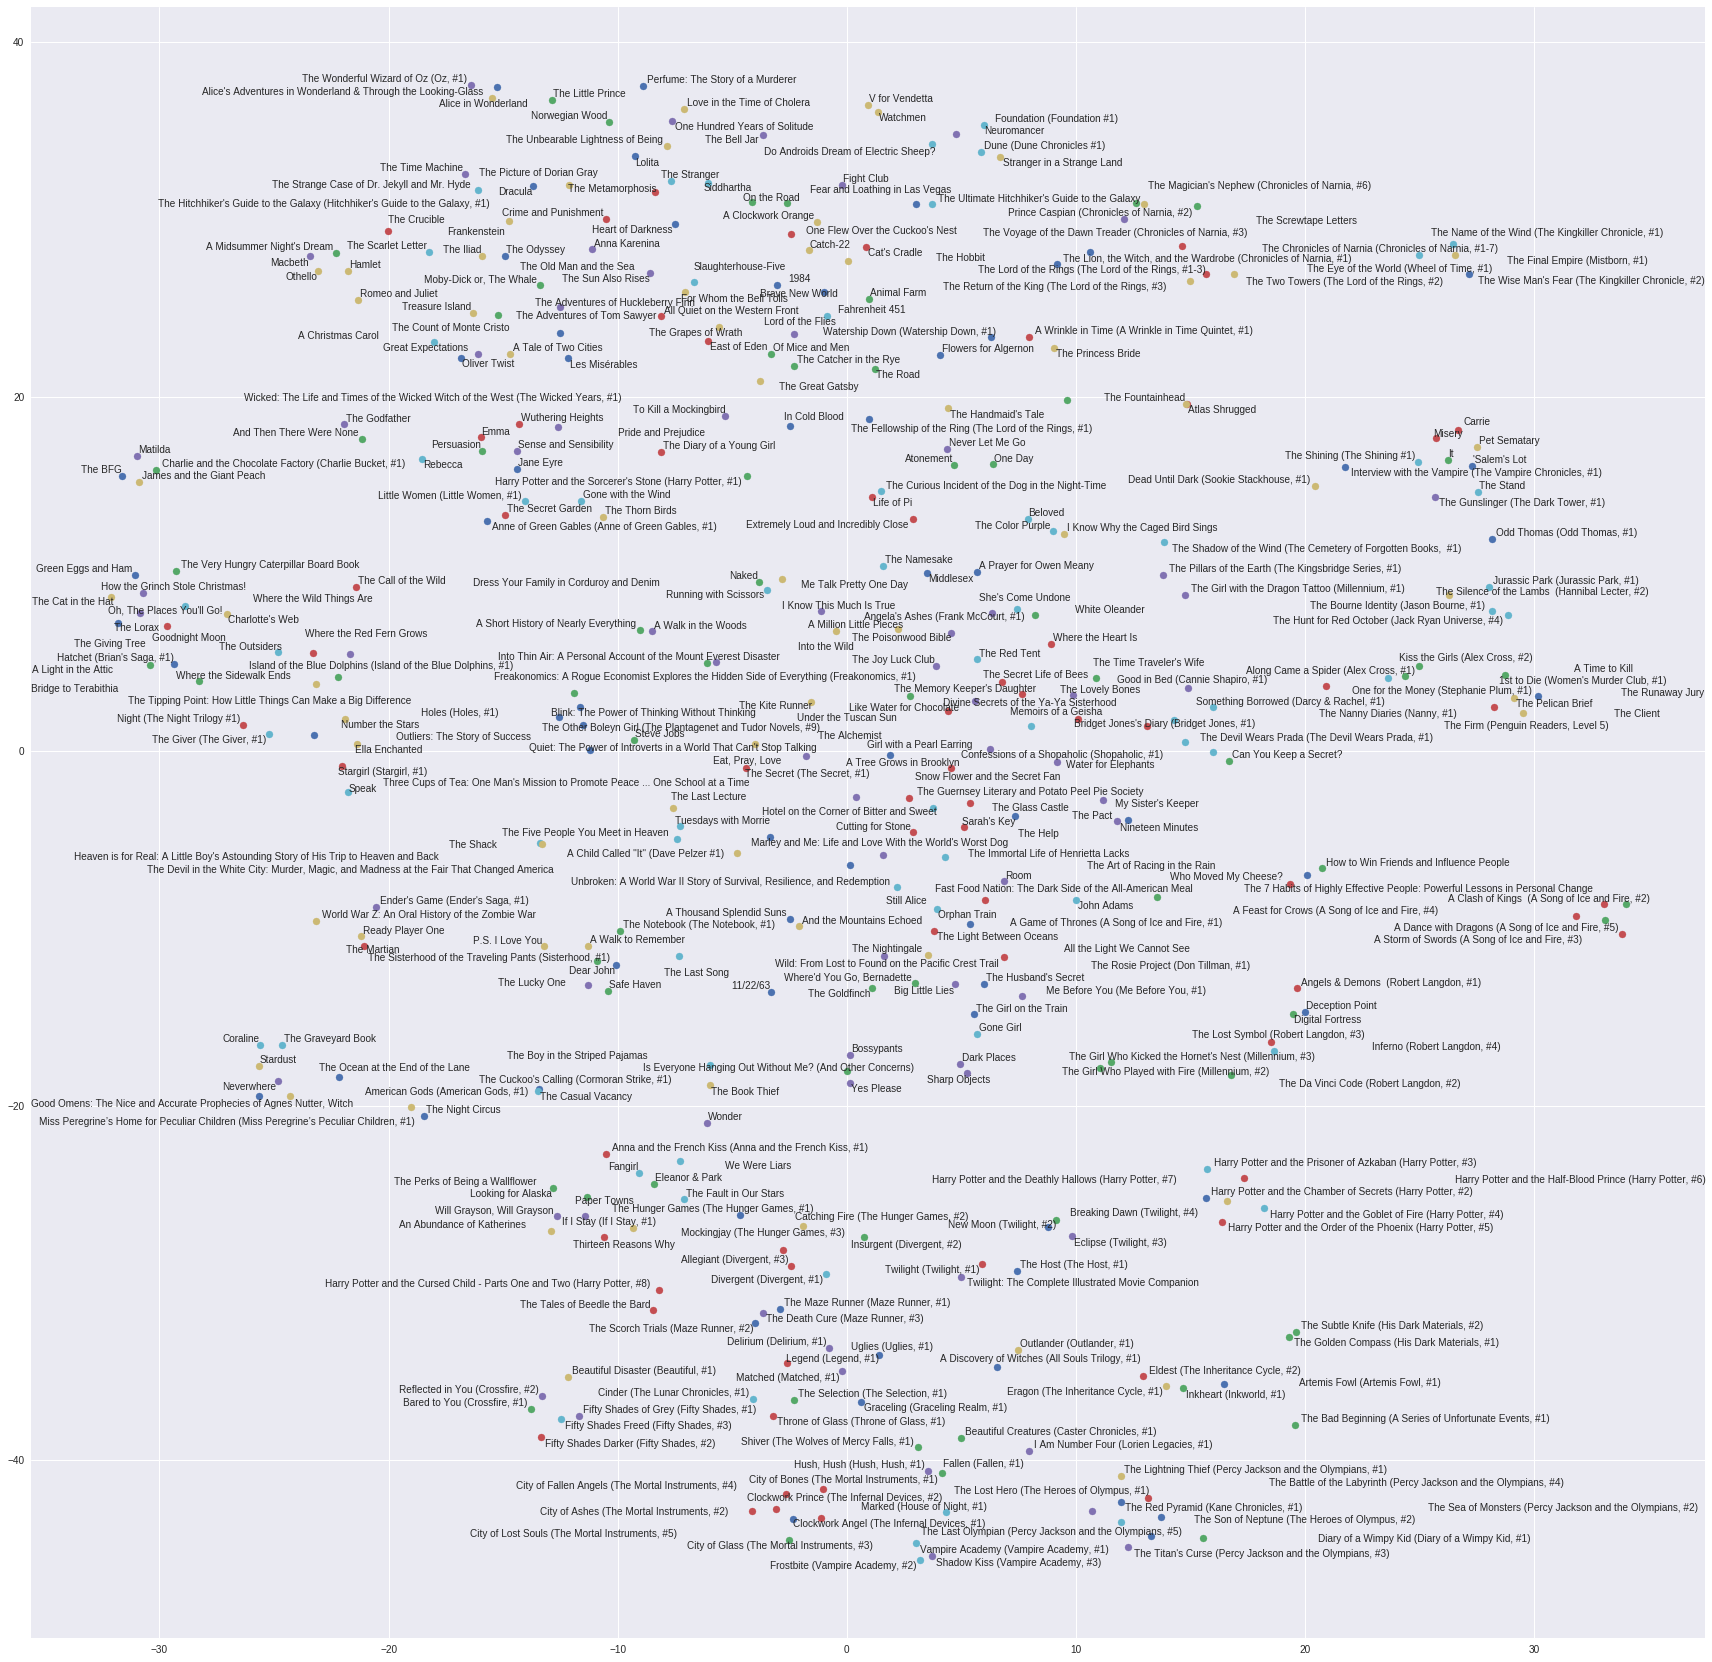

In [48]:
#Plot book embeddings 

texts = []

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pyplot.figure(figsize=(30, 30))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pyplot.scatter(x, y)
    #pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   #ha='right', va='bottom')
    texts.append(pyplot.text(x, y, label)) #Creates better plots but takes a long time. To save time, comment this, and uncomment the pyplot.annotate line
  adjust_text(texts , arrowprops=dict(arrowstyle='->', color='red'))
  pyplot.show()

plot(two_d_embeddings, books)


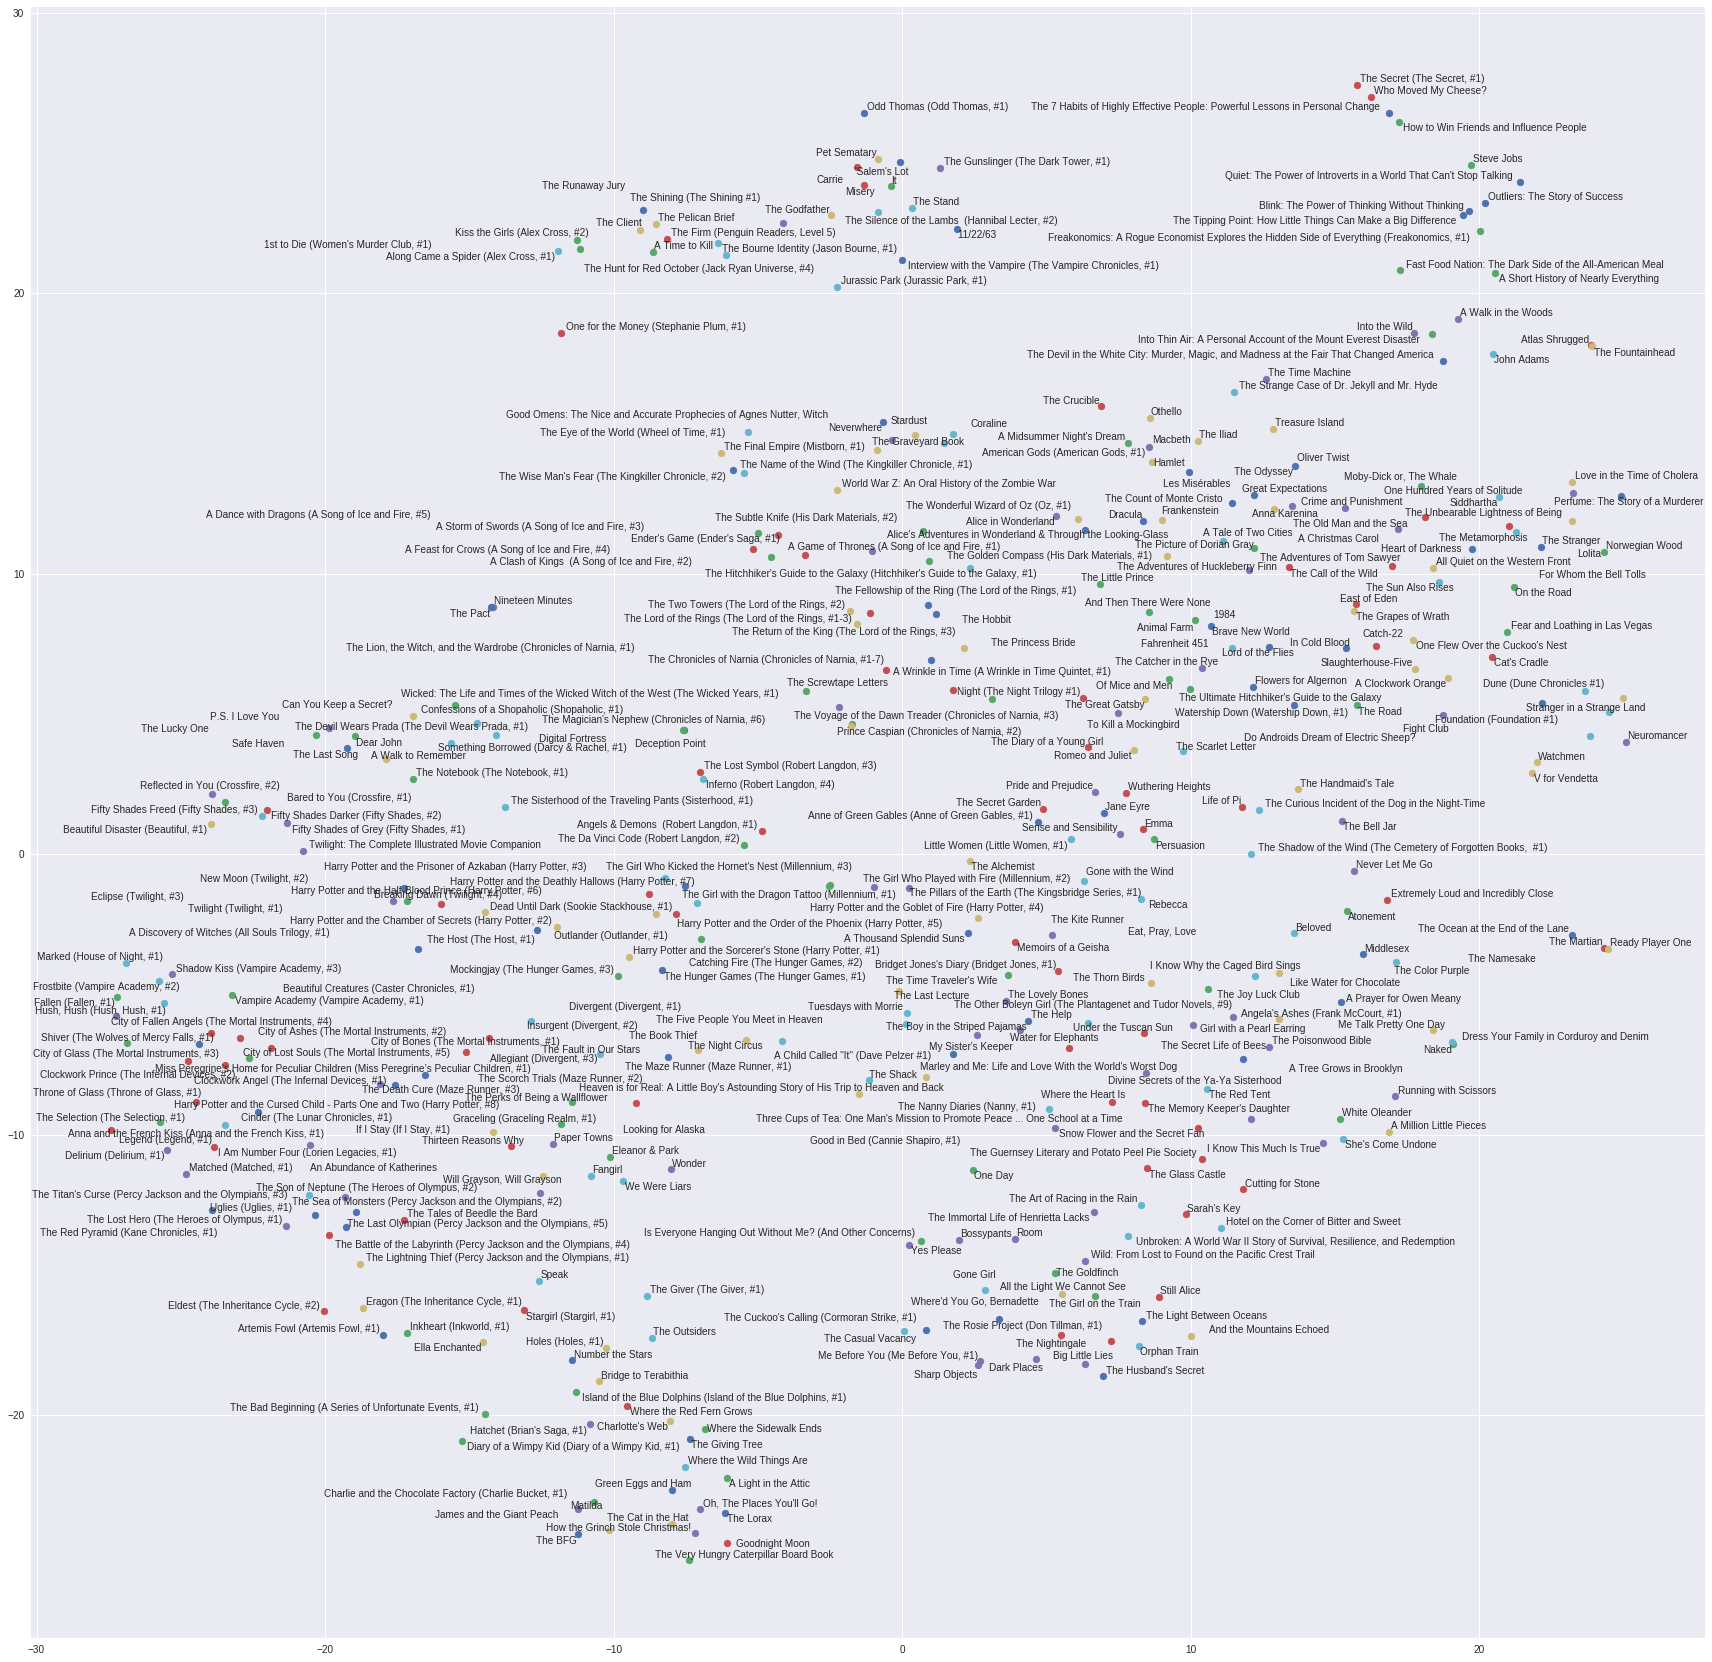

array([[-8.31457901e+00, -4.13505602e+00],
       [-6.96744299e+00, -3.04499650e+00],
       [-1.59965954e+01, -1.77377450e+00],
       [ 7.46126413e+00,  5.01632261e+00],
       [ 8.42813015e+00,  5.52623510e+00],
       [-1.04654074e+01, -7.13449669e+00],
       [ 1.15761459e+00,  8.56191254e+00],
       [ 9.22608566e+00,  6.23017931e+00],
       [-4.87133551e+00,  8.35963666e-01],
       [ 6.68459988e+00,  2.21883130e+00],
       [ 2.62657666e+00, -2.27209163e+00],
       [-1.28792934e+01, -5.93831205e+00],
       [ 1.07107496e+01,  8.12699127e+00],
       [ 1.01340246e+01,  8.32818508e+00],
       [ 6.42505550e+00,  3.80386829e+00],
       [-9.77510512e-01, -1.17529964e+00],
       [-9.47312069e+00, -3.66946626e+00],
       [-8.21043110e+00, -8.60110104e-01],
       [ 8.93413961e-01,  8.88456535e+00],
       [-9.84997082e+00, -4.33404732e+00],
       [-7.82856703e+00, -2.13487792e+00],
       [ 3.58762527e+00, -5.24301720e+00],
       [-8.52137375e+00, -2.14364934e+00],
       [-7.

In [50]:
#Plot book softmax embeddings 

texts = []

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pyplot.figure(figsize=(30, 30))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pyplot.scatter(x, y)
    #pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   #ha='right', va='bottom')
    texts.append(pyplot.text(x, y, label)) #Creates better plots but takes a long time. To save time, comment this, and uncomment the pyplot.annotate line
  adjust_text(texts , arrowprops=dict(arrowstyle='->', color='red'))
  pyplot.show()

plot(two_d_embeddingsSM, books)
two_d_embeddingsSM
